### Example taken from *A Low-Complexity Quantum Principal Component Analysis Algorithm*
https://doi.org/10.1109/TQE.2021.3140152

In [1]:
import numpy as np
import itertools
from qiskit_experiments.library import StateTomography
from qiskit.visualization import plot_state_city,array_to_latex
import qiskit.quantum_info as qi
from qiskit.visualization import plot_histogram
from qiskit.circuit.library.standard_gates import RYGate
from qiskit import Aer, transpile, execute
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.algorithms.linear_solvers.matrices.numpy_matrix import NumPyMatrix
from qiskit.circuit.library import PhaseEstimation
import matplotlib.pyplot as plt
from qiskit import BasicAer, execute
import scipy as sc
import pandas as pd
from QPCA.decomposition.Qpca import QPCA
from qiskit.circuit.library.data_preparation.state_preparation import *
from QPCA.preprocessingUtilities.preprocessing_matrix_utilities import generate_matrix
#9329 con 6 res
#seed 10 con resolution 5
#6476 cambiando eigenvalues a 0.55 e 0.45 ris=7
# 12 con 4x4 matrix e risoluzione 7
#500  4x4 cambiando autovalori.
#4524
#8908
#4747 res 8
#6752
np.random.seed(19)

'''example_matrix=np.random.rand(3,3)


example_matrix=np.dot(example_matrix,example_matrix.T)
#example_matrix=np.array([[1.5,0.5],[0.5,1.5]])
#example_matrix=np.array([[0,0,0,0],[0.,1.,0,0],[0.,0.,2,0],[0.,0,0,3]])
sum_squares = (example_matrix**2).sum()
input_probabilities = (example_matrix**2/sum_squares).flatten()

print(input_probabilities)'''

'example_matrix=np.random.rand(3,3)\n\n\nexample_matrix=np.dot(example_matrix,example_matrix.T)\n#example_matrix=np.array([[1.5,0.5],[0.5,1.5]])\n#example_matrix=np.array([[0,0,0,0],[0.,1.,0,0],[0.,0.,2,0],[0.,0,0,3]])\nsum_squares = (example_matrix**2).sum()\ninput_probabilities = (example_matrix**2/sum_squares).flatten()\n\nprint(input_probabilities)'

In [2]:
example_matrix=generate_matrix(matrix_dimension=2,replicate_paper=False,seed=19)

Matrix:
 [[0.59 0.13]
 [0.13 0.08]]

eigenvalue: 0.04912229458049476 - eigenvector: [-0.233  0.973]
eigenvalue: 0.6199503657038241 - eigenvector: [0.973 0.233]


In [3]:
example_matrix1=example_matrix/np.trace(example_matrix)
example_matrix1,np.linalg.eig(example_matrix1)

(array([[0.88034375, 0.19315908],
        [0.19315908, 0.11965625]]),
 (array([0.92658152, 0.07341848]),
  array([[ 0.9725247 , -0.23279972],
         [ 0.23279972,  0.9725247 ]])))

In [4]:
sum_squares = (example_matrix**2).sum()
input_probabilities = (example_matrix**2/sum_squares).flatten()

In [5]:
print(input_probabilities)

[0.89705523 0.04318619 0.04318619 0.0165724 ]


In [6]:
#Tommaso's great code for computing the thetas
def thetas_computation(example_matrix):
    lst_combination=[]

    for k in range(1, int(np.ceil(np.log2(len(example_matrix)**2)))+1):
        lst_combination.append(list(map(list, itertools.product([0, 1], repeat=k))))
    container=[]
    for lst in lst_combination:
        container.append([''.join([''.join(str(j)) for j in i]) for i in lst])
    all_combinations=[item for c in container for item in c]

    general_bitstring=[''.join([''.join(str(j)) for j in i]) for i in list(map(list, itertools.product([0, 1], repeat=int(np.ceil(np.log2(len(example_matrix)**2))))))][:len(input_probabilities)]
    
    #Nodes contains all the values of the tree (except for the root)
    nodes=[]
    for st in all_combinations:
        #print(st)
        starts = [general_bitstring.index(l) for l in general_bitstring if l.startswith(st)]
        #print(starts)
        print(st,'->',np.sqrt(input_probabilities[starts].sum()))
        nodes.append(np.sqrt(input_probabilities[starts].sum()))
    
    #add root tree
    nodes.insert(0, 1)
    thetas=[]

    idx=0
    for i in range(1,len(nodes),2):
        
        right_node=i
        left_node=right_node+1
        if nodes[idx]!=0:
            thetas.append(2*np.arccos(nodes[right_node]/nodes[idx]))
            thetas.append(2*np.arcsin(nodes[left_node]/nodes[idx]))
        else:
            thetas.append(0)
            thetas.append(0)

        idx+=1
    return thetas, all_combinations

# SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")

# for idx,th in zip(all_combinations,thetas):
#     print('\u03F4(R{})'.format((str(idx).translate(SUB))),'->', th)
#thetas

In [7]:
def generate_qram_circuit(thetas, all_combinations):
    
    right_nodes_indexes=list(range(0,len(thetas),2))
    rotations_list=list(zip(np.array(all_combinations)[right_nodes_indexes],np.array(thetas)[right_nodes_indexes]))

    #qc=QuantumCircuit(len(example_matrix))
    qc=QuantumCircuit(int(np.ceil(np.log2(len(example_matrix)**2))))

    for r_l in rotations_list:
        target_qubit=len(r_l[0])-1
        
        #First case of R_0
        if target_qubit==0:
            qc.ry(theta=r_l[1],qubit=target_qubit)
            continue
            
        not_gate=[]
        for qb in range(target_qubit):
            if r_l[0][qb]=='0':
                not_gate.append(qb)
                
        c_t_qubits=list(range(len(r_l[0])))
        n_controls=len(range(target_qubit))
        
        if len(not_gate)>0:
            qc.x(not_gate)
            c_ry = RYGate(r_l[1]).control(n_controls)
            qc.append(c_ry, c_t_qubits)
            qc.x(not_gate)
        else:
            c_ry = RYGate(r_l[1]).control(n_controls)
            qc.append(c_ry, c_t_qubits)
    return qc

0 -> 0.9696604633240288
1 -> 0.24445569305342432
00 -> 0.9471299950763292
01 -> 0.20781286428054138
10 -> 0.20781286428054138
11 -> 0.1287338312400718


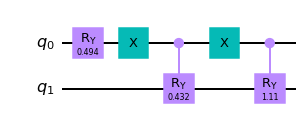

In [8]:
thetas, all_combinations = thetas_computation(example_matrix1)
matrix_circuit = generate_qram_circuit(thetas, all_combinations)
matrix_circuit.draw('mpl')

In [9]:
#Check matrix encoding
backend = Aer.get_backend("statevector_simulator")
job = backend.run(transpile(matrix_circuit, backend=backend))
job.result().get_counts()

/opt/miniconda3/envs/EAGLE_environment/lib/python3.8/site-packages/numpy/linalg/linalg.py:2139: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/miniconda3/envs/EAGLE_environment/lib/python3.8/site-packages/numpy/linalg/linalg.py:2139: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


{'00': 0.897055227573288,
 '01': 0.043186186560483,
 '10': 0.043186186560483,
 '11': 0.016572399305747}

In [167]:
#Unitary for PE
resolution = 3
unitary_backend = Aer.get_backend("unitary_simulator")
u_circuit = NumPyMatrix(example_matrix1, evolution_time=2*np.pi)
unitary_job = unitary_backend.run(transpile(u_circuit, backend=unitary_backend))
unitary_job.result().get_unitary()

/var/folders/rr/g930v2cj1wvdzc257kclm3lm0000gn/T/ipykernel_4825/2942357963.py:4: DeprecationWarning: The NumPyMatrix class is deprecated as of Qiskit Terra 0.22.0 and will be removed no sooner than 3 months after the release date. 
  u_circuit = NumPyMatrix(example_matrix1, evolution_time=2*np.pi)


Operator([[ 8.95473769e-01-0.39686772j, -2.46828593e-17-0.20155084j],
          [-2.46828593e-17-0.20155084j,  8.95473769e-01+0.39686772j]],
         input_dims=(2,), output_dims=(2,))

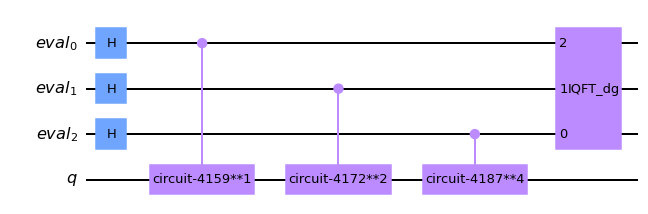

In [168]:
#PE circuit
pe = PhaseEstimation(resolution, u_circuit, name = "PE")
pe.decompose().draw("mpl")

# Check Statevector

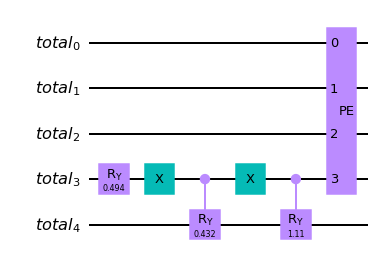

In [169]:
tot_qubit = resolution+len(example_matrix1)

qr_total_sim = QuantumRegister(tot_qubit, 'total')
# classical = ClassicalRegister(4, 'measure')

total_circuit_sim = QuantumCircuit(qr_total_sim , name='matrix')

total_circuit_sim.append(matrix_circuit.to_gate(), qr_total_sim[resolution:])
total_circuit_sim.append(pe.to_gate(), qr_total_sim[0:pe.num_qubits])
# total_circuit.measure(qr_total[:2], classical[:])
#total_circuit.swap(qr_total[0],qr_total[1])
#total_circuit.measure_all()

total_circuit_sim.decompose(reps=1).draw("mpl")

In [266]:
aer_back=Aer.get_backend('statevector_simulator')
st=aer_back.run(transpile(total_circuit_sim,aer_back)).result().get_statevector()
print(st)

Statevector([-0.02180733-4.93516136e-01j,  0.11694962-5.07472444e-03j,
              0.09087367-9.90699696e-02j,  0.15922228+1.45934966e-01j,
              0.06779396-1.85519842e-01j,  0.1317776 +4.79927130e-02j,
              0.10477238-4.88111828e-02j,  0.2975478 +6.38064176e-01j,
             -0.00478482-1.28078386e-01j,  0.02566029-1.31700357e-03j,
              0.01856819-2.07974107e-02j,  0.03630617+3.29599168e-02j,
              0.0102673 -3.16299733e-02j,  0.02945533+1.05138229e-02j,
              0.02244687-1.07262339e-02j,  0.06989352+1.49075267e-01j,
             -0.00478482-1.28078386e-01j,  0.02566029-1.31700357e-03j,
              0.01856819-2.07974107e-02j,  0.03630617+3.29599168e-02j,
              0.0102673 -3.16299733e-02j,  0.02945533+1.05138229e-02j,
              0.02244687-1.07262339e-02j,  0.06989352+1.49075267e-01j,
             -0.00296405+1.08744846e-02j,  0.01589578+1.11820078e-04j,
              0.01774953-1.71668536e-02j,  0.01624349+1.61341971e-02j,
      

/opt/miniconda3/envs/EAGLE_environment/lib/python3.8/site-packages/numpy/linalg/linalg.py:2139: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/miniconda3/envs/EAGLE_environment/lib/python3.8/site-packages/numpy/linalg/linalg.py:2139: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


In [269]:
bitstrings=[''.join([''.join(str(j)) for j in i]) for i in list(map(list, itertools.product([0, 1], repeat=resolution+len(example_matrix1))))]
sim_statevector=attach_bitstrings(st)
sim_statevector

/var/folders/rr/g930v2cj1wvdzc257kclm3lm0000gn/T/ipykernel_4825/1621592731.py:2: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  return list(zip(bitstrings, vector))


[('00000', (-0.02180732505198514-0.49351613556052054j)),
 ('00001', (0.11694961641467072-0.0050747244402920555j)),
 ('00010', (0.09087367191628418-0.09906996958187494j)),
 ('00011', (0.15922228341326122+0.1459349655997j)),
 ('00100', (0.06779396181590747-0.185519842397488j)),
 ('00101', (0.1317776028907286+0.047992713046637395j)),
 ('00110', (0.10477238414524744-0.04881118279539398j)),
 ('00111', (0.2975477995322151+0.6380641761292324j)),
 ('01000', (-0.004784815922744183-0.12807838565969315j)),
 ('01001', (0.025660294669143775-0.0013170035732310431j)),
 ('01010', (0.018568191891769975-0.02079741068159814j)),
 ('01011', (0.03630617286512127+0.03295991683166276j)),
 ('01100', (0.010267301482622991-0.03162997334922993j)),
 ('01101', (0.02945532664116768+0.010513822858719912j)),
 ('01110', (0.02244687327544398-0.010726233915985511j)),
 ('01111', (0.06989351937801577+0.14907526748935518j)),
 ('10000', (-0.004784815922744214-0.1280783856596931j)),
 ('10001', (0.025660294669143838-0.00131700

# Grover

In [170]:
from qiskit.algorithms import AmplificationProblem
from qiskit.circuit.library import GroverOperator


In [171]:
general_bitstring=[''.join([''.join(str(j)) for j in i]) for i in list(map(list, itertools.product([0, 1], repeat=len(example_matrix1)+resolution)))]
general_bitstring

['00000',
 '00001',
 '00010',
 '00011',
 '00100',
 '00101',
 '00110',
 '00111',
 '01000',
 '01001',
 '01010',
 '01011',
 '01100',
 '01101',
 '01110',
 '01111',
 '10000',
 '10001',
 '10010',
 '10011',
 '10100',
 '10101',
 '10110',
 '10111',
 '11000',
 '11001',
 '11010',
 '11011',
 '11100',
 '11101',
 '11110',
 '11111']

In [172]:
decimal_bitstring=[int(g_b[-resolution:],base=2)/(2**resolution) for g_b in general_bitstring]
decimal_bitstring

[0.0,
 0.125,
 0.25,
 0.375,
 0.5,
 0.625,
 0.75,
 0.875,
 0.0,
 0.125,
 0.25,
 0.375,
 0.5,
 0.625,
 0.75,
 0.875,
 0.0,
 0.125,
 0.25,
 0.375,
 0.5,
 0.625,
 0.75,
 0.875,
 0.0,
 0.125,
 0.25,
 0.375,
 0.5,
 0.625,
 0.75,
 0.875]

In [173]:
threshold=0.5
good_states=np.array(general_bitstring)[np.array(decimal_bitstring)>=threshold]
good_states

array(['00100', '00101', '00110', '00111', '01100', '01101', '01110',
       '01111', '10100', '10101', '10110', '10111', '11100', '11101',
       '11110', '11111'], dtype='<U5')

In [174]:
init_statevector=Statevector.from_label(good_states[0])

for g in good_states[1:]:
    st=Statevector.from_label(g)
    init_statevector+=st
init_statevector

Statevector([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
             1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 1.+0.j,
             1.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j,
             1.+0.j, 1.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j],
            dims=(2, 2, 2, 2, 2))


In [175]:
normalized_statevector=init_statevector/np.sqrt(np.sum(np.array(init_statevector)**2))
normalized_statevector

Statevector([0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.25+0.j, 0.25+0.j,
             0.25+0.j, 0.25+0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j,
             0.25+0.j, 0.25+0.j, 0.25+0.j, 0.25+0.j, 0.  +0.j, 0.  +0.j,
             0.  +0.j, 0.  +0.j, 0.25+0.j, 0.25+0.j, 0.25+0.j, 0.25+0.j,
             0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.25+0.j, 0.25+0.j,
             0.25+0.j, 0.25+0.j],
            dims=(2, 2, 2, 2, 2))


In [244]:
oracle = QuantumCircuit(3)
oracle.ccz(0, 1, 2)

theta = 2 * np.arccos(1 / np.sqrt(5))
state_preparation = QuantumCircuit(5)
state_preparation.ry(theta, 0)
state_preparation.ch(0,1)
state_preparation.x(1)
state_preparation.h(2)
state_preparation.ry(theta,3)
state_preparation.ry(theta,4)
state_preparation.draw()

┌────────────┐          
q_0: ┤ Ry(2.2143) ├──■───────
     └────────────┘┌─┴─┐┌───┐
q_1: ──────────────┤ H ├┤ X ├
         ┌───┐     └───┘└───┘
q_2: ────┤ H ├───────────────
     ┌───┴───┴────┐          
q_3: ┤ Ry(2.2143) ├──────────
     ├────────────┤          
q_4: ┤ Ry(2.2143) ├──────────
     └────────────┘

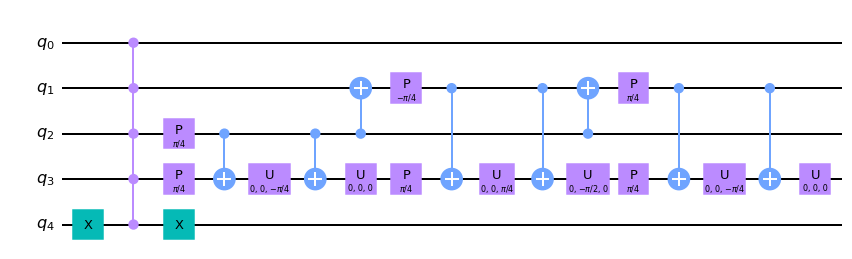

In [302]:
from qiskit.circuit.library.phase_oracle import PhaseOracle
expression = '(a & b & c & d & e) | (e & d & b & ~a & c)| (~e & d & b & ~a & c)'
#expression = '(c & d & e) | (~c&d&e)'
phaseOracle=PhaseOracle(expression)
'''state_preparation=QuantumCircuit(5)
for i in range(5):
    state_preparation.h(i)'''
groverOperator=GroverOperator(oracle=phaseOracle,insert_barriers=True)
expression_problem = AmplificationProblem(phaseOracle,grover_operator=groverOperator)
display(expression_problem.grover_operator.oracle.decompose().draw(output='mpl'))

In [180]:
state_preparation.draw()

┌───┐
q_0: ┤ H ├
     ├───┤
q_1: ┤ H ├
     ├───┤
q_2: ┤ H ├
     ├───┤
q_3: ┤ H ├
     ├───┤
q_4: ┤ H ├
     └───┘

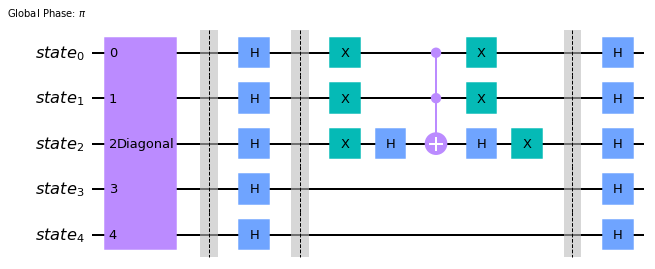

In [110]:
groverOperator=GroverOperator(oracle=normalized_statevector,state_preparation=state_preparation,reflection_qubits=[0,1,2],insert_barriers=True)
problem=AmplificationProblem(oracle=normalized_statevector,state_preparation=state_preparation,is_good_state=list(good_states),grover_operator=groverOperator)

problem.grover_operator.decompose().draw(output='mpl')

In [33]:
from qiskit.algorithms import Grover
from qiskit.primitives import Sampler

In [115]:

grover = Grover(sampler=Sampler(),iterations=2)
result = grover.amplify(problem)
print('Result type:', type(result))
print()
print('Success!' if result.oracle_evaluation else 'Failure!')
print('Top measurement:', result.top_measurement)

Result type: <class 'qiskit.algorithms.amplitude_amplifiers.grover.GroverResult'>

Failure!
Top measurement: 00000


In [116]:
result.circuit_results

[{'00000': 0.031249999999999837,
  '00001': 0.031249999999999837,
  '00010': 0.031249999999999837,
  '00011': 0.031249999999999837,
  '00100': 0.031249999999999837,
  '00101': 0.031249999999999837,
  '00110': 0.031249999999999837,
  '00111': 0.031249999999999837,
  '01000': 0.031249999999999837,
  '01001': 0.031249999999999837,
  '01010': 0.031249999999999837,
  '01011': 0.031249999999999837,
  '01100': 0.031249999999999837,
  '01101': 0.031249999999999837,
  '01110': 0.031249999999999837,
  '01111': 0.031249999999999837,
  '10000': 0.031249999999999837,
  '10001': 0.031249999999999837,
  '10010': 0.031249999999999837,
  '10011': 0.031249999999999837,
  '10100': 0.031249999999999837,
  '10101': 0.031249999999999837,
  '10110': 0.031249999999999837,
  '10111': 0.031249999999999837,
  '11000': 0.031249999999999837,
  '11001': 0.031249999999999837,
  '11010': 0.031249999999999837,
  '11011': 0.031249999999999837,
  '11100': 0.031249999999999837,
  '11101': 0.031249999999999837,
  '11110':

In [306]:
(np.pi/4)*np.sqrt((2**5)/3)

2.565099660323728

In [311]:

grover = Grover(sampler=Sampler(),iterations=2)
result_1 = grover.amplify(expression_problem)
print('Result type:', type(result))
print()
print('Success!' if result.oracle_evaluation else 'Failure!')
print('Top measurement:', result.top_measurement)

Result type: <class 'qiskit.algorithms.amplitude_amplifiers.grover.GroverResult'>

Failure!
Top measurement: 00000


In [312]:
result_1.circuit_results

[{'00000': 7.629394531250114e-06,
  '00001': 7.629394531250102e-06,
  '00010': 7.629394531250762e-06,
  '00011': 7.629394531250468e-06,
  '00100': 7.6293945312497976e-06,
  '00101': 7.629394531249876e-06,
  '00110': 7.629394531250398e-06,
  '00111': 7.6293945312498645e-06,
  '01000': 7.629394531250401e-06,
  '01001': 7.629394531250234e-06,
  '01010': 7.62939453125043e-06,
  '01011': 7.629394531250495e-06,
  '01100': 7.6293945312501e-06,
  '01101': 7.629394531250612e-06,
  '01110': 0.3332595825195289,
  '01111': 7.629394531250737e-06,
  '10000': 7.62939453125122e-06,
  '10001': 7.629394531250418e-06,
  '10010': 7.629394531250615e-06,
  '10011': 7.629394531250493e-06,
  '10100': 7.629394531250056e-06,
  '10101': 7.629394531250427e-06,
  '10110': 7.629394531250495e-06,
  '10111': 7.629394531250884e-06,
  '11000': 7.629394531250593e-06,
  '11001': 7.629394531250612e-06,
  '11010': 7.629394531249567e-06,
  '11011': 7.629394531250954e-06,
  '11100': 7.629394531250554e-06,
  '11101': 7.629394

In [16]:
# Create the first operator for tomography
op_U=total_circuit_sim.to_gate(label='op_U').control()

In [17]:
backend_total = Aer.get_backend("statevector_simulator")
job = backend_total.run(transpile(total_circuit_sim, backend=backend_total))
statevector = np.asarray(job.result().get_statevector()).round(4)
#plot_histogram(counts)

In [267]:
def attach_bitstrings(vector):
    return list(zip(bitstrings, vector))

In [19]:
bitstrings=[''.join([''.join(str(j)) for j in i]) for i in list(map(list, itertools.product([0, 1], repeat=resolution+len(example_matrix1))))]
sim_statevector=attach_bitstrings(statevector)


In [20]:
int(np.log2(len(sim_statevector))-4)

8

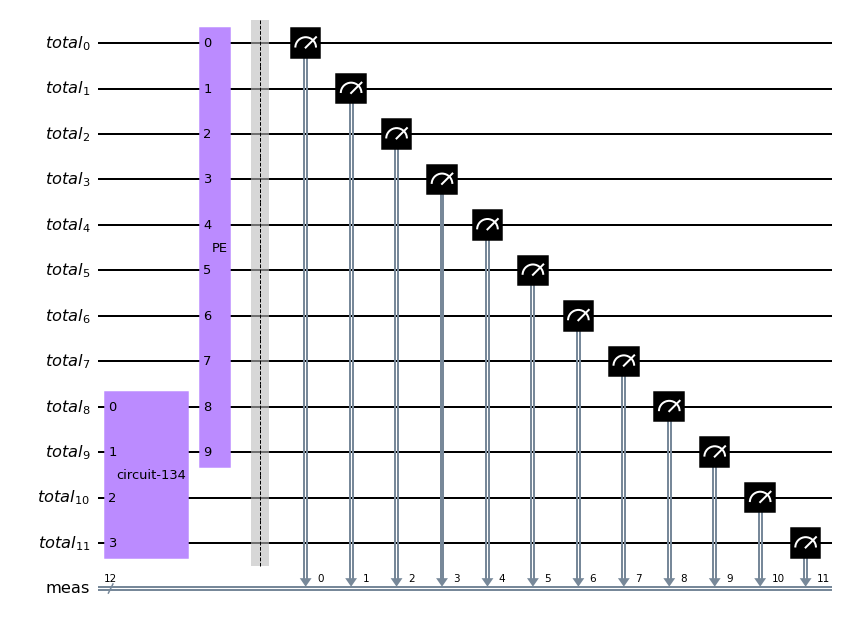

In [21]:
tot_qubit = resolution+len(example_matrix1)
#print(tot_qubit)
qr_total = QuantumRegister(tot_qubit, 'total')

total_circuit = QuantumCircuit(qr_total, name='matrix')

total_circuit.append(matrix_circuit.to_gate(), qr_total[resolution:])
total_circuit.append(pe.to_gate(), qr_total[0:pe.num_qubits])
#total_circuit.barrier()
total_circuit.measure_all()
total_circuit.draw("mpl")

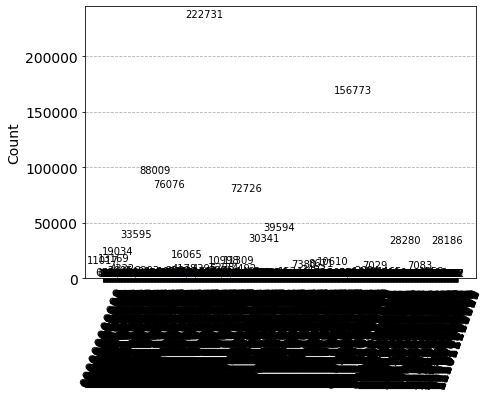

In [22]:
n_shots=1000000
backend_total = Aer.get_backend("qasm_simulator")
job = backend_total.run(transpile(total_circuit, backend=backend_total), shots=n_shots)
counts = job.result().get_counts()
plot_histogram(counts)

In [23]:
for i in counts:
    counts[i]/=n_shots
#counts

In [24]:
statevector=np.zeros(2**tot_qubit)
for i in counts:
    statevector[int(i,2)]=counts[i]
#statevector

In [25]:
#Create second operator tomography
op_V = StatePreparation(np.sqrt(statevector),label='c_V').control()

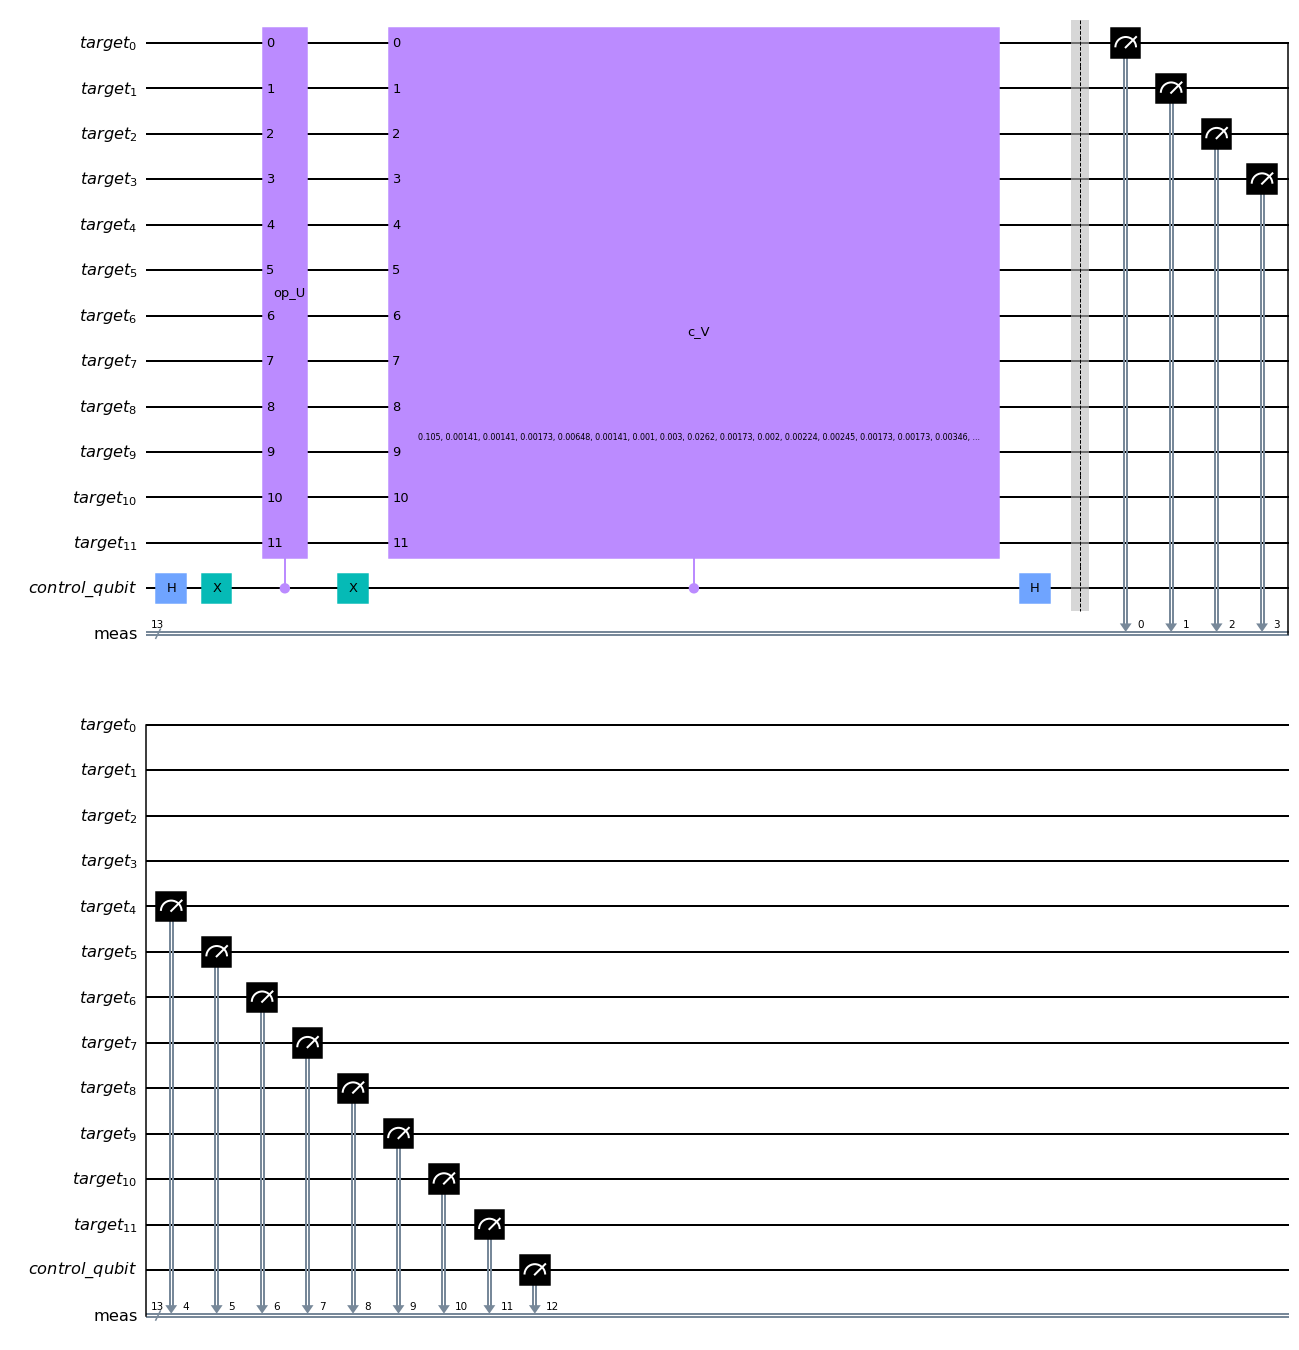

In [26]:

tot_qubit = resolution+len(example_matrix)

qr_total_xi = QuantumRegister(tot_qubit, 'target')
qr_control = QuantumRegister(1, 'control_qubit')

total_circuit_2 = QuantumCircuit(qr_total_xi,qr_control, name='matrix')
total_circuit_2.h(qr_control)
total_circuit_2.x(qr_control)

total_circuit_2.append(op_U, qr_control[:]+qr_total_xi[:])
total_circuit_2.x(qr_control)
total_circuit_2.append(op_V, qr_control[:]+qr_total_xi[:])
total_circuit_2.h(qr_control)
total_circuit_2.measure_all()
total_circuit_2.draw("mpl")

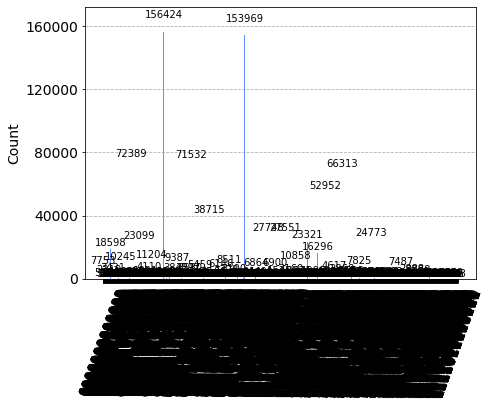

In [27]:
backend_total = Aer.get_backend("qasm_simulator")
job = backend_total.run(transpile(total_circuit_2, backend=backend_total), shots=n_shots)
counts_for_sign = job.result().get_counts()
plot_histogram(counts_for_sign)

In [28]:
#Take only counts with control qubits equal to 0
tmp=np.zeros(2**tot_qubit)
for c in counts_for_sign:
    if c[0]=='0':
        tmp[int(c[1:],2)]=counts_for_sign[c]
#tmp

In [92]:
###Metodo Nannicini

'''tmp_=tmp/(sum(tmp))

sign_diff=[]
sign=[]
x_list=[]
for i in range(len(tmp_)):
    x=(np.sqrt(statevector[i])*0.5)+(((statevector[i])/np.sqrt(statevector[i]))*0.5) - (tmp_[i]/(2*np.sqrt(statevector[i])))
    
    x_list.append(x)
    
    sign_diff.append(np.sign(x)+np.sign((sim_statevector[i][1].real)))
    sign.append(np.sign(x))
    '''

'tmp_=tmp/(sum(tmp))\n\nsign_diff=[]\nsign=[]\nx_list=[]\nfor i in range(len(tmp_)):\n    x=(np.sqrt(statevector[i])*0.5)+(((statevector[i])/np.sqrt(statevector[i]))*0.5) - (tmp_[i]/(2*np.sqrt(statevector[i])))\n    \n    x_list.append(x)\n    \n    sign_diff.append(np.sign(x)+np.sign((sim_statevector[i][1].real)))\n    sign.append(np.sign(x))\n    '

In [29]:
#Sign estimation
sign_dictionary={}
sign=0
for e, (count, prob) in enumerate(zip(tmp, statevector)):
    if count>0.4*prob*n_shots:
        sign=1
    else:
        sign=-1
    if prob==0:
        sign=1
    sign_dictionary.update({bin(e)[2:].zfill(tot_qubit):sign})

In [30]:
statevector_dictionary={}
for e,key in enumerate(sign_dictionary):
    statevector_dictionary[key]=sign_dictionary[key]*np.sqrt(statevector[e])

#statevector_dictionary

In [31]:
bitstrings=[''.join([''.join(str(j)) for j in i]) for i in list(map(list, itertools.product([0, 1], repeat=resolution+len(example_matrix1))))]
ss=attach_bitstrings(statevector)
#ss

In [32]:
df=pd.DataFrame(ss)

df.columns=['state','module']
df

,state,module
0,000000000000,0.011017
1,000000000001,0.000002
2,000000000010,0.000002
3,000000000011,0.000003
4,000000000100,0.000042
...,...,...
4091,111111111011,0.000000
4092,111111111100,0.000000
4093,111111111101,0.000000
4094,111111111110,0.000000


In [33]:
df['lambda']=df['state'].apply(lambda x: x[-resolution:])
df1=df.groupby('lambda').agg({'module':'sum'})
#df1['module_new']=df1['module'].apply(lambda x: np.sqrt(x.real**2 + x.imag**2))
df1=df1.sort_values('module',ascending=False)
df1

,module
lambda,
00110111,0.374577
10000000,0.271382
11001000,0.140531
00000000,0.092162
00101000,0.021515
...,...
01111110,0.000003
01000110,0.000003
11111001,0.000003


In [34]:
tail=df1.reset_index()
tail

,lambda,module
0,00110111,0.374577
1,10000000,0.271382
2,11001000,0.140531
3,00000000,0.092162
4,00101000,0.021515
...,...,...
251,01111110,0.000003
252,01000110,0.000003
253,11111001,0.000003
254,01011110,0.000003


In [35]:
tail['num']=tail['lambda'].apply(lambda x :int(x[::-1],base=2)/(2**resolution))

In [36]:
tail.head(20)

,lambda,module,num
0,00110111,0.374577,0.921875
1,10000000,0.271382,0.003906
2,11001000,0.140531,0.074219
3,00000000,0.092162,0.000000
4,00101000,0.021515,0.078125
5,01000000,0.019760,0.007812
6,11111111,0.013775,0.996094
7,01001000,0.006876,0.070312
8,11000000,0.006539,0.011719
9,01111111,0.005297,0.992188


In [101]:
'''tail1['num']+=0.1
tail1'''

"tail1['num']+=0.1\ntail1"

In [37]:
np.linalg.eig(example_matrix1)

(array([0.92221665, 0.07531465, 0.0024687 , 0.        ]),
 array([[-0.43714001, -0.82468914,  0.35888219,  0.        ],
        [-0.2051187 , -0.29709624, -0.93255571,  0.        ],
        [-0.87569112,  0.48127086,  0.03928651,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]))

In [38]:
from scipy.signal import find_peaks

peaks=[]
nums_peaks=[]
offset=1/n_shots
stop=False
while stop==False:
    right_thresholds=find_peaks(tail.sort_values(['num'])['module'],threshold=offset)[1]['right_thresholds']
    left_thresholds=find_peaks(tail.sort_values(['num'])['module'],threshold=offset)[1]['left_thresholds']
    mean=(right_thresholds+left_thresholds)/2
    p=find_peaks(tail.sort_values(['num'])['module'],threshold=offset)[0]
    if len(p)>len(example_matrix1):
        offset+=1/n_shots
    else:
        stop=True
        for i in p:
            el = tail.sort_values(['num']).iloc[i]
            nums_peaks.append(el['num'])
            peaks.append(el['lambda'])

sorted_peaks=np.array(peaks)[mean.argsort()[::-1]]
sorted_num_peaks=np.array(nums_peaks)[mean.argsort()[::-1]]
peaks,np.array(nums_peaks)

(['10000000', '11001000', '01111011', '00110111'],
 array([0.00390625, 0.07421875, 0.8671875 , 0.921875  ]))

In [39]:
sorted_num_peaks

array([0.921875  , 0.00390625, 0.07421875, 0.8671875 ])

In [40]:
np.array(nums_peaks)[np.argwhere(mean != np.amin(mean))]

array([[0.00390625],
       [0.07421875],
       [0.921875  ]])

In [158]:
min_=10000
values_not_to_keep=[]
for k in np.array(nums_peaks)[~np.argwhere(mean == np.amin(mean))]:
    a=find_nearest(np.linalg.eig(example_matrix1)[0],k[0])
    gg=abs(a-k[0])
    if gg<min_:
        min_=gg
        value_to_keep=k[0]
    

print(value_to_keep)


0.84765625


In [148]:
idx=[list(sorted_num_peaks).index(x) for x in values_not_to_keep if x in sorted_num_peaks]
idx

[2]

In [157]:
values_not_to_keep=[v for v in np.array(nums_peaks)[np.argwhere(mean == np.amin(mean))] if v!=value_to_keep]
values_not_to_keep

[array([0.84765625])]

In [143]:
new_peaks=[v for v in sorted_num_peaks if v not in values_not_to_keep]
new_peaks

[0.84765625, 0.09375]

In [104]:
right_thresholds,left_thresholds

(array([0.01, 0.01, 0.95]), array([0.01, 0.01, 0.95]))

In [64]:
(right_thresholds+left_thresholds)/2

array([0.004, 0.002, 0.98 ])

In [41]:
sorted_peaks,sorted_num_peaks,right_thresholds

(array(['00110111', '10000000', '11001000', '01111011'], dtype='<U8'),
 array([0.921875  , 0.00390625, 0.07421875, 0.8671875 ]),
 array([2.51622e-01, 1.19016e-01, 2.20000e-05, 3.71010e-01]))

In [303]:
check_eigenvalues={}
for i in np.linalg.eig(example_matrix1)[0]:
    check_eigenvalues.update({i:0})
check_eigenvalues

{0.8955238958986377: 0,
 0.00030420453127693393: 0,
 0.05567682172622658: 0,
 0.04849507784385881: 0}

In [125]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [305]:
for s_p in sorted_num_peaks:
    x=find_nearest(np.linalg.eig(example_matrix1)[0],s_p)
    print(x)
    if check_eigenvalues[x]==0:
        check_eigenvalues.update({x:1})
    else:
        continue
print(check_eigenvalues)

0.8955238958986377
0.05567682172622658
0.04849507784385881
{0.8955238958986377: 1, 0.00030420453127693393: 0, 0.05567682172622658: 1, 0.04849507784385881: 1}


In [306]:
new_original_eigenvalues=[]
for d in list(check_eigenvalues.keys()):
    if check_eigenvalues[d]==1:
        check_eigenvalues.pop(d)
        new_original_eigenvalues.append(d)
        #new_original_eigenvalues.append(d)
        #del check_eigenvalues[d]
check_eigenvalues

{0.00030420453127693393: 0}

In [307]:
if len(check_eigenvalues)>0:
    new_original_eigenvalues.append(list(check_eigenvalues.keys())[0])
else:
    new_original_eigenvalues=sorted(new_original_eigenvalues,reverse=True)
new_original_eigenvalues

[0.8955238958986377,
 0.05567682172622658,
 0.04849507784385881,
 0.00030420453127693393]

In [317]:
np.linalg.eig(example_matrix1),np.linalg.eig(example_matrix1)[1][:,1]

((array([8.95523896e-01, 3.04204531e-04, 5.56768217e-02, 4.84950778e-02]),
  array([[-0.54010974, -0.31079311, -0.76691778,  0.15338266],
         [-0.34101425, -0.72369209,  0.45528741, -0.39075876],
         [-0.54078131,  0.59128095,  0.021657  , -0.59789078],
         [-0.54730826,  0.17339042,  0.45175377,  0.68286746]])),
 array([-0.31079311, -0.72369209,  0.59128095,  0.17339042]))

In [334]:
new_idx=[]
for i in new_original_eigenvalues:
    for j in range(len(np.linalg.eig(example_matrix1)[0])):
        if i==np.linalg.eig(example_matrix1)[0][j]:
            new_idx.append(np.linalg.eig(example_matrix1)[1][:,j])
            
new_idx=np.array(new_idx)

In [336]:
new_idx.reshape(4,4).T

array([[-0.54010974, -0.76691778,  0.15338266, -0.31079311],
       [-0.34101425,  0.45528741, -0.39075876, -0.72369209],
       [-0.54078131,  0.021657  , -0.59789078,  0.59128095],
       [-0.54730826,  0.45175377,  0.68286746,  0.17339042]])

In [306]:
peaks=[]
nums_peaks=[]
peaks.append(tail.iloc[0]['lambda'])
nums_peaks.append(tail.iloc[0]['num'])
for i in range(1,len(tail)):
    
    #for n_ in nums_peaks:
        
    if any(abs(tail.iloc[i]['num']-n_)<= 4/(2**resolution) for n_ in nums_peaks):
        #if any(abs(tail1.iloc[i]['num']-n_)/n_<= 0.2 for n_ in nums_peaks):
        pass
    else:
           
        nums_peaks.append(tail.iloc[i]['num'])
        peaks.append(tail.iloc[i]['lambda'])
        pass
    if len(peaks)==len(example_matrix1):
        break
    #print(tail.iloc[i])

In [307]:
peaks,np.array(nums_peaks)

(['010011011', '100011000', '010000000', '001110000'],
 array([0.84765625, 0.09570312, 0.00390625, 0.0546875 ]))

In [478]:
np.linalg.eig(example_matrix1)

(array([8.95523896e-01, 3.04204531e-04, 5.56768217e-02, 4.84950778e-02]),
 array([[-0.54010974, -0.31079311, -0.76691778,  0.15338266],
        [-0.34101425, -0.72369209,  0.45528741, -0.39075876],
        [-0.54078131,  0.59128095,  0.021657  , -0.59789078],
        [-0.54730826,  0.17339042,  0.45175377,  0.68286746]]))

<AxesSubplot: xlabel='num'>

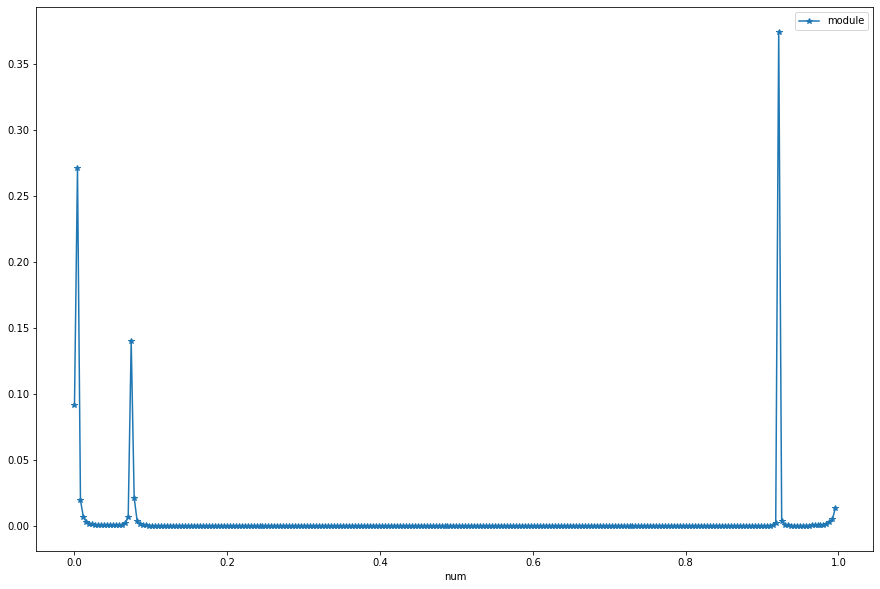

In [42]:
tail[['num','module']].sort_values('num').set_index('num').plot(style='-*',figsize=(15,10))

In [149]:
'''lambdas=df1.tail(len(example_matrix1)).index.values
lambdas'''

'lambdas=df1.tail(len(example_matrix1)).index.values\nlambdas'

In [43]:
lambdas=peaks
lambdas

['10000000', '11001000', '01111011', '00110111']

In [44]:
df.columns=['state','module','lambda']
df

,state,module,lambda
0,000000000000,0.011017,00000000
1,000000000001,0.000002,00000001
2,000000000010,0.000002,00000010
3,000000000011,0.000003,00000011
4,000000000100,0.000042,00000100
...,...,...,...
4091,111111111011,0.000000,11111011
4092,111111111100,0.000000,11111100
4093,111111111101,0.000000,11111101
4094,111111111110,0.000000,11111110


In [45]:
df['sign']=np.array(list(sign_dictionary.values()))
#df['sign']=np.array(sign)
df

,state,module,lambda,sign
0,000000000000,0.011017,00000000,1
1,000000000001,0.000002,00000001,1
2,000000000010,0.000002,00000010,1
3,000000000011,0.000003,00000011,-1
4,000000000100,0.000042,00000100,-1
...,...,...,...,...
4091,111111111011,0.000000,11111011,1
4092,111111111100,0.000000,11111100,1
4093,111111111101,0.000000,11111101,1
4094,111111111110,0.000000,11111110,1


In [46]:
df['module']=df['module'].multiply(np.array(list(sign_dictionary.values())), axis=0)
#df['module']=df['module'].multiply(np.array(sign), axis=0)
df=df.fillna(0)
df

,state,module,lambda,sign
0,000000000000,0.011017,00000000,1
1,000000000001,0.000002,00000001,1
2,000000000010,0.000002,00000010,1
3,000000000011,-0.000003,00000011,-1
4,000000000100,-0.000042,00000100,-1
...,...,...,...,...
4091,111111111011,0.000000,11111011,1
4092,111111111100,0.000000,11111100,1
4093,111111111101,0.000000,11111101,1
4094,111111111110,0.000000,11111110,1


In [47]:
#df['st']=sim_statevector

In [155]:
df.query("state.str.endswith('01111000')")

,state,module,lambda,sign


In [48]:
a=[]
save_sign=[]
eigenvalues=[]
for l in lambdas:
    eigenvalues.append(int(l[::-1],base=2)/(2**resolution))
    a_=np.array(df.query("state.str.endswith(@l)")['module'].values)
    #print(a_)
    save_sign.append(np.sign(a_))
    #print(save_sign)
    
    a.append(np.sqrt(abs(a_)))

#a=[a1,a2]

for i in range(len(a)):
    print(a[i])
    normalization_factor=np.sqrt((1/(sum(a[i]**2))))
    print(normalization_factor)
    a[i]*=normalization_factor
    a[i]*=save_sign[i]
    
    print(a)

[0.18328939 0.47194385 0.01954482 0.         0.03903844 0.10300485
 0.00608276 0.         0.01224745 0.03310589 0.00173205 0.
 0.01236932 0.03313608 0.00173205 0.        ]
1.9195944279350001
[array([-0.35184129,  0.90594079, -0.03751813,  0.        ,  0.07493798,
       -0.19772754, -0.01167644,  0.        ,  0.02351013, -0.06354988,
        0.00332484,  0.        ,  0.02374407, -0.06360784, -0.00332484,
        0.        ]), array([0.29666311, 0.10487135, 0.17418668, 0.        , 0.08590693,
       0.03170173, 0.05180734, 0.        , 0.00574456, 0.00223607,
       0.00360555, 0.        , 0.00648074, 0.00282843, 0.00360555,
       0.        ]), array([0.00316228, 0.00565685, 0.001     , 0.        , 0.00244949,
       0.00141421, 0.00223607, 0.        , 0.001     , 0.001     ,
       0.001     , 0.        , 0.001     , 0.001     , 0.002     ,
       0.        ]), array([0.13796376, 0.06463745, 0.26967759, 0.        , 0.19898241,
       0.0931182 , 0.3959457 , 0.        , 0.08383913, 0.03

In [49]:
eigenvalues

[0.00390625, 0.07421875, 0.8671875, 0.921875]

In [50]:
#TODO: Capire se fare la media tra i vari fattori di rescaling
eigenvectors=[]
for ll, eig in zip(a,eigenvalues):
    
    eigenvector=np.zeros(len(example_matrix1)) #put length of eigenvector
    save_sign=np.sign(ll)
    sv=abs(ll)
    max_list=[]
    scaled_statevectors=[]
    for e,i in enumerate(range(0,len(sv),len(example_matrix1))):
        max_list.append(max(sv[i:i+len(example_matrix1)]))
        scaled_statevectors.append(sv[i:i+len(example_matrix1)]/max_list[e])
        #print(max_list,scaled_statevectors)
    idx_max=np.argmax(max_list)
    #print(idx_max)
    max_max=max_list[idx_max]
    #print(max_max)
    value=np.sqrt(max_max)
    #eigenvector=scaled_statevectors[idx_max]*value*save_sign[:len(example_matrix)]
    eigenvector=scaled_statevectors[idx_max]*value*save_sign[len(example_matrix1)*idx_max:len(example_matrix1)*idx_max+len(example_matrix1)]
    eigenvectors.append((eig,eigenvector))
    print('reconstructed_eigenvector:',eigenvector)
    print('reconstructed_eigenvalue:', eig)
    

reconstructed_eigenvector: [-0.36965527  0.95180922 -0.0394177   0.        ]
reconstructed_eigenvalue: 0.00390625
reconstructed_eigenvector: [ 0.88958763  0.31447205 -0.52232419  0.        ]
reconstructed_eigenvalue: 0.07421875
reconstructed_eigenvector: [ 0.46825688  0.83764337 -0.14807583  0.        ]
reconstructed_eigenvalue: 0.8671875
reconstructed_eigenvector: [0.40421423 0.18916096 0.8043268  0.        ]
reconstructed_eigenvalue: 0.921875


In [51]:
np.array(eigenvalues)*np.trace(example_matrix)

array([0.01114745, 0.21180152, 2.47473358, 2.63079786])

In [52]:
np.linalg.eig(example_matrix1)#,np.linalg.eig(example_matrix2)

(array([0.92221665, 0.07531465, 0.0024687 , 0.        ]),
 array([[-0.43714001, -0.82468914,  0.35888219,  0.        ],
        [-0.2051187 , -0.29709624, -0.93255571,  0.        ],
        [-0.87569112,  0.48127086,  0.03928651,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]))

NameError: name 'eig' is not defined